Import the necessary packages.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
pd.set_option('display.max_columns',100)

In [70]:
import warnings
warnings.filterwarnings('ignore')

Specify the path of the training dataset.

In [71]:
path_train = 'train.json/train.json'

Reads the json file to a pandas dataframe.

In [72]:
cuisine_train_df = pd.read_json(path_train, orient = 'columns')

In [73]:
cuisine_train_df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [74]:
cuisine_train_df.shape

(39774, 3)

Check for missing values in the training dataset


In [75]:
cuisine_train_df.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

Plot the distribution of different cuisines.

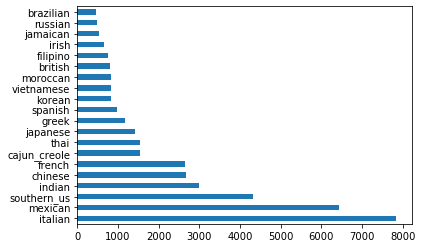

In [76]:
cuisine_train_df['cuisine'].value_counts().plot(kind="barh")

In [77]:
cuisine_train_df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


Create a lemmatized version of the ingredients.

In [78]:
lemma = WordNetLemmatizer()

In [79]:
lemma_ing = []
for i in range(cuisine_train_df.shape[0]):
    lemma_ing.append([lemma.lemmatize(x) for x in cuisine_train_df['ingredients'].iloc[i]])

In [80]:
cuisine_train_df['lemmatized_ingredients'] = lemma_ing

In [81]:
cuisine_train_df.head()

,id,cuisine,ingredients,lemmatized_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[plain flour, ground pepper, salt, tomato, gro..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[egg, pepper, salt, mayonaise, cooking oil, gr..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[black pepper, shallot, cornflour, cayenne pep..."


Convert the column from having list values to string values of ingredients.

In [82]:
cuisine_train_df['lemmatized_ingredients'] = cuisine_train_df['lemmatized_ingredients'].apply(lambda x: ", ".join( str(e) for e in x ))

In [83]:
cuisine_train_df['lemmatized_ingredients'] = cuisine_train_df['lemmatized_ingredients'].str.replace(',',' ')

In [84]:
cuisine_train_df.head()

,id,cuisine,ingredients,lemmatized_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomato grou...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",egg pepper salt mayonaise cooking oil gre...
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallot cornflour cayenne pepp...


Creating the document term matrix.

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(stop_words='english',
                      ngram_range=(1,1),
                      analyzer='word')

In [86]:
cuisine_train_dtm = vect.fit_transform(cuisine_train_df['lemmatized_ingredients']).todense()

In [87]:
print(cuisine_train_dtm.shape)

(39774, 3003)


Train the model and test it on a subset of the training data.

In [88]:
from sklearn.model_selection import train_test_split

X = cuisine_train_df['lemmatized_ingredients']
y = cuisine_train_df['cuisine']

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [89]:
x_test.head()

21513    pork  cooking oil  bamboo shoots  chinese rice...
1796     hog casings  hungarian paprika  ancho powder  ...
21861    lamb stock  lemon  lamb shoulder  onion  groun...
26571    green peas  cinnamon sticks  clove  chopped on...
28720    vegetable oil spray  cumin seed  grated parmes...
Name: lemmatized_ingredients, dtype: object

In [90]:
y_test[:5]

21513    chinese
1796     spanish
21861      greek
26571     indian
28720    italian
Name: cuisine, dtype: object

Convert the target classs labels to numerical values.

In [91]:
from sklearn.preprocessing import LabelEncoder

X_train = vect.fit_transform(x_train).todense()
X_test = vect.transform(x_test).todense()

le = LabelEncoder()
le.fit(y_train)
y1 = le.transform(y_train)

y2 = le.transform(y_test)


In [92]:
y2[:5]

array([ 3, 17,  6,  7,  9])

In [93]:
target_labels = list(le.classes_)

Train the TFIDF model.

In [94]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
log_tr = logreg.fit(X_train,y1)


In [95]:
from sklearn.metrics import accuracy_score,confusion_matrix

pred_log = log_tr.predict(X_test)
acc_log = accuracy_score(pred_log,y2)

In [96]:
# Get the accuracy of the model
acc_log

0.7832809553739787

In [97]:
C = confusion_matrix(y2, pred_log)

<Figure size 3600x1080 with 0 Axes>

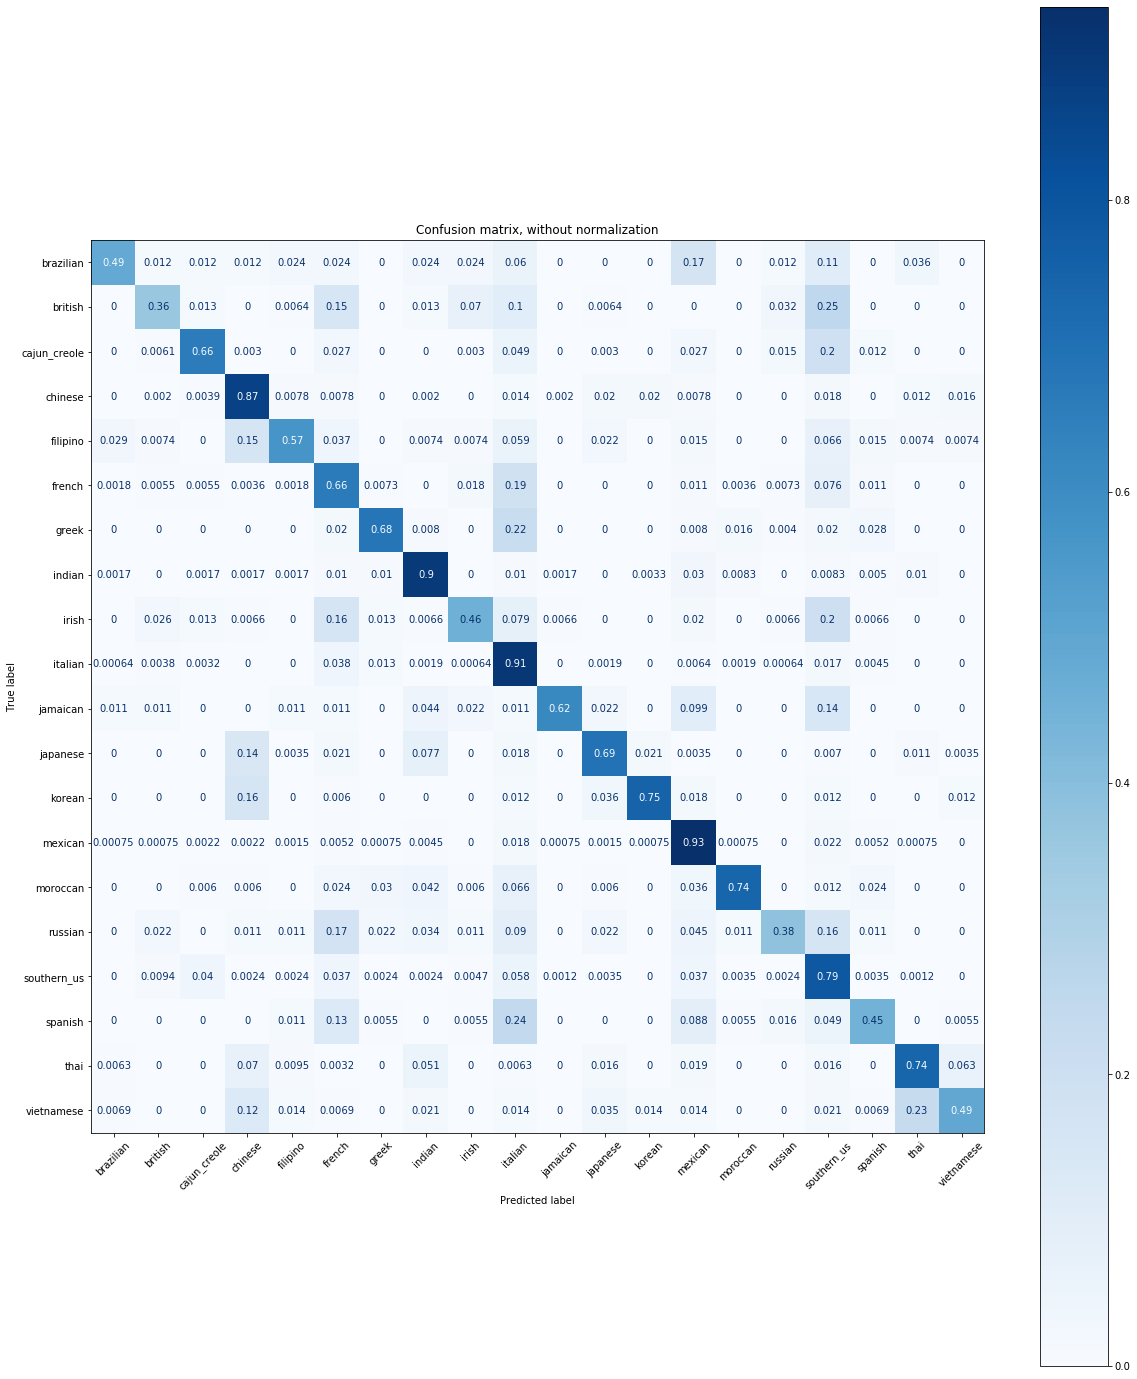

In [98]:
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None)]

for title, normalize in titles_options:
    plt.figure(figsize=(50,15))
    from pylab import rcParams
    rcParams['figure.figsize'] = 20, 25
    disp = plot_confusion_matrix(log_tr, X_test, y2,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

    
    disp.ax_.set_title(title)
    if list(le.classes_) is not None:
        tick_marks = np.arange(len(target_labels))
        plt.xticks(tick_marks, target_labels, rotation=45)
        plt.yticks(tick_marks, target_labels)

    
plt.show()